*best viewed in [nbviewer](https://nbviewer.jupyter.org/github/CambridgeSemiticsLab/BH_time_collocations/blob/master/results/notebooks/adverbial_components.ipynb)*

# Time Adverbial Components
### Cody Kingham
<a href="../../docs/sponsors.md"><img height=200px width=200px align="left" src="../../docs/images/CambridgeU_BW.png"></a>

In [1]:
! echo "last updated:"; date

last updated:
Wed 20 May 2020 14:43:14 BST


## Introduction

This notebook will produce data for my in-progress article on time adverbial components. 
This notebook will also act as a pathfinder for a refined approach to time adverbial dataset.
As such, we will rely on the modified BHSA data directly rather than using the dataset stored
in `data/main_dataset`.

<hr>

# Python

Now we import the modules and data needed for the analysis.

In [2]:
# standard & data science packages
import collections
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['font.serif'] = ['SBL Biblit']
import seaborn as sns
from bidi.algorithm import get_display # bi-directional text support for plotting

# custom packages (see /tools)
import paths
import stats.significance as mystats
from tf_tools.load import load_tf
from positions import Walker, Positions
import tf_tools.formatting as form

# launch Text-Fabric with custom data
TF, API, A = load_tf('funct_assoc nhead', silent='deep')
A.displaySetup(condenseType='phrase')
F, E, T, L = A.api.F, A.api.E, A.api.T, A.api.L # corpus analysis methods

# set paths
from pathlib import Path
x_data_path = paths.data.joinpath('x_dataset/')

## Pathfinder dataset for all phrase functions

In [9]:
phrase_dataset = []

for phrase in F.otype.s('phrase'):
    book, chapter, verse = T.sectionFromNode(phrase)
    sentence = L.u(phrase, 'sentence')[0]
    ref = f'{form.book2sbl[book]} {chapter}:{verse}'
    function = F.function.v(phrase)
    s_function = form.simplified_functions.get(function, function)
    n_words = len(L.d(phrase, 'word'))
    n_phrase_atoms = len(L.d(phrase, 'phrase_atom'))
    heads = E.nhead.t(phrase)
    n_heads = len(heads)
    head_lexs = '|'.join(F.lex.v(h) for h in heads)
    daughters = E.mother.t(phrase)
    n_daughters = len(daughters)
    d_relas = '|'.join(F.rela.v(d) for d in daughters)
    ph_typ = F.typ.v(phrase)
    rela = F.rela.v(phrase)
    time_phrase = L.u(phrase, 'timephrase')
    
    phrase_dataset.append({
        'node': phrase,
        'ref': ref,
        'text': T.text(phrase),
        'sentence': T.text(sentence),
        'type': ph_typ,
        'function': function,
        's_function': s_function,
        'rela': rela,
        'n_words': n_words,
        'n_phrase_atoms': n_phrase_atoms,
        'n_heads': n_heads,
        'head_lexs': head_lexs,
        'n_daughters': n_daughters,
        'daught_relas': d_relas or np.nan,
        'in_timephrase': bool(time_phrase),
    })
    
print(len(phrase_dataset), 'phrases collected...')

253207 phrases collected...


In [10]:
phrase_df = pd.DataFrame(phrase_dataset)
phrase_df.set_index('node', inplace=True)

In [11]:
phrase_df.head()

,ref,text,sentence,type,function,s_function,rela,n_words,n_phrase_atoms,n_heads,head_lexs,n_daughters,daught_relas,in_timephrase
node,,,,,,,,,,,,,,
651542,Gen 1:1,בְּרֵאשִׁ֖ית,בְּרֵאשִׁ֖ית בָּרָ֣א אֱלֹהִ֑ים אֵ֥ת הַשָּׁמַ֖י...,PP,Time,Time,NA,2,1,1,R>CJT/,0,NaN,True
651543,Gen 1:1,בָּרָ֣א,בְּרֵאשִׁ֖ית בָּרָ֣א אֱלֹהִ֑ים אֵ֥ת הַשָּׁמַ֖י...,VP,Pred,Pred,NA,1,1,1,BR>[,0,NaN,False
651544,Gen 1:1,אֱלֹהִ֑ים,בְּרֵאשִׁ֖ית בָּרָ֣א אֱלֹהִ֑ים אֵ֥ת הַשָּׁמַ֖י...,NP,Subj,Subj,NA,1,1,1,>LHJM/,0,NaN,False
651545,Gen 1:1,אֵ֥ת הַשָּׁמַ֖יִם וְאֵ֥ת הָאָֽרֶץ׃,בְּרֵאשִׁ֖ית בָּרָ֣א אֱלֹהִ֑ים אֵ֥ת הַשָּׁמַ֖י...,PP,Objc,Objc,NA,7,1,2,CMJM/|>RY/,0,NaN,False
651546,Gen 1:2,וְ,וְהָאָ֗רֶץ הָיְתָ֥ה תֹ֨הוּ֙ וָבֹ֔הוּ,CP,Conj,Conj,NA,1,1,1,W,0,NaN,False


Let's get some phrase statistics in order to see how many simple/complex phrases we have. 
We use a few features to measure "complexity":

    1. number of phrase_atoms
    2. number of heads
    3. number of daughters

In [13]:
n_atoms = phrase_df.n_phrase_atoms.value_counts()
n_heads = phrase_df.n_heads.value_counts()
n_daughts = phrase_df.n_daughters.value_counts()

print('n_atoms')
display(n_atoms)

print('\nn_heads')
display(n_heads)

print('\nn_daughters')
display(n_daughts)

n_atoms


1     243407
2       7494
3       1295
4        481
5        266
6        103
7         58
8         41
9         21
11        15
10        13
12         7
15         2
14         2
16         1
13         1
Name: n_phrase_atoms, dtype: int64


n_heads


1     245523
2       5554
3       1320
4        485
5        147
6         85
7         55
8         17
9          8
10         5
12         3
11         3
14         2
Name: n_heads, dtype: int64


n_daughters


0    247749
1      5137
2       293
3        25
4         2
6         1
Name: n_daughters, dtype: int64

Let's look closer at number of atoms by correlating the counts with
phrase functions. Are there any dependent relationships?

In [52]:
functXatoms = pd.pivot_table(
    phrase_df, 
    index='s_function', 
    columns='n_phrase_atoms',
    aggfunc='size',
).fillna(0)

functXwords = pd.pivot_table(
    phrase_df, 
    index='s_function', 
    columns='n_words',
    aggfunc='size',
).fillna(0)

Let's have a look at the frequencies of the various phrase functions. The corresponding values
for each of the codes is supplied just below.

In [47]:
functXatoms.sum(1).sort_values(ascending=False)

s_function
Pred    63523.0
Conj    46152.0
Subj    31952.0
Cmpl    30036.0
Objc    22668.0
PreC    19395.0
Adju     9514.0
Rela     6328.0
Nega     6044.0
Time     4677.0
Modi     3168.0
Loca     2625.0
Intj     1872.0
Voct     1607.0
Ques     1200.0
Frnt     1137.0
NCop      698.0
PrAd      246.0
Supp      178.0
Exst      157.0
EPPr       22.0
PrcS        8.0
dtype: float64

In [16]:
form.funct2function

{'Adju': 'Adjunct',
 'Cmpl': 'Complement',
 'Conj': 'Conjunction',
 'EPPr': 'Enclitic personal pronoun',
 'ExsS': 'Existence with subject suffix',
 'Exst': 'Existence',
 'Frnt': 'Fronted element',
 'Intj': 'Interjection',
 'IntS': 'Interjection with subject suffix',
 'Loca': 'Location',
 'Modi': 'Modifier',
 'ModS': 'Modifier with subject suffix',
 'NCop': 'Negative copula',
 'NCoS': 'Negative copula with subject suffix',
 'Nega': 'Negation',
 'Objc': 'Object',
 'PrAd': 'Predicative adjunct',
 'PrcS': 'Predicate complement with subject suffix',
 'PreC': 'Predicate complement',
 'Pred': 'Predicate',
 'PreO': 'Predicate with object suffix',
 'PreS': 'Predicate with subject suffix',
 'PtcO': 'Participle with object suffix',
 'Ques': 'Question',
 'Rela': 'Relative',
 'Subj': 'Subject',
 'Supp': 'Supplementary constituent',
 'Time': 'Time',
 'Unkn': 'Unknown',
 'Voct': 'Vocative'}

Let's have a look at the minor cases. Those are the phrase functions 
which have a lower frequency. 

In [38]:
functXatoms.loc[functXatoms.sum(1) < 1000]

n_phrase_atoms,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
s_function,,,,,,,,,,,,,,,,
EPPr,22.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Exst,157.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
NCop,698.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PrAd,227.0,16.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PrcS,5.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Supp,178.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [60]:
functXatoms_top = functXatoms.loc[functXatoms.sum(1) > 1000]

functXatoms_top

n_phrase_atoms,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
s_function,,,,,,,,,,,,,,,,
Adju,8735.0,581.0,132.0,23.0,23.0,14.0,3.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
Cmpl,28023.0,1602.0,246.0,79.0,52.0,11.0,9.0,4.0,4.0,1.0,3.0,2.0,0.0,0.0,0.0,0.0
Conj,46152.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Frnt,955.0,120.0,40.0,12.0,6.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Intj,1872.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Loca,2382.0,182.0,36.0,10.0,10.0,3.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
Modi,3118.0,46.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Nega,6044.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Objc,20976.0,1163.0,265.0,114.0,77.0,30.0,14.0,13.0,8.0,2.0,3.0,1.0,0.0,1.0,1.0,0.0


In [67]:
desc = functXatoms_top.T.describe()

desc

s_function,Adju,Cmpl,Conj,Frnt,Intj,Loca,Modi,Nega,Objc,PreC,Pred,Ques,Rela,Subj,Time,Voct
count,16.000000,16.000000,16.0,16.000000,16.0,16.000000,16.000000,16.00,16.000000,16.000000,16.000000,16.000000,16.0,16.000000,16.000000,16.000000
mean,594.625000,1877.250000,2884.5,71.062500,117.0,164.062500,198.000000,377.75,1416.750000,1212.187500,3970.187500,75.000000,395.5,1997.000000,292.312500,100.437500
std,2175.610501,6983.502278,11538.0,237.685357,468.0,593.177373,778.750538,1511.00,5223.796518,4501.242795,15873.017794,299.733437,1582.0,7236.374295,1073.968201,353.471351
min,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
25%,0.000000,0.750000,0.0,0.000000,0.0,0.000000,0.000000,0.00,1.000000,0.000000,0.000000,0.000000,0.0,3.250000,0.000000,0.000000
50%,1.500000,4.000000,0.0,0.000000,0.0,0.500000,0.000000,0.00,10.500000,2.500000,0.000000,0.000000,0.0,14.000000,0.500000,0.000000
75%,23.000000,58.750000,0.0,7.500000,0.0,10.000000,0.250000,0.00,86.250000,44.250000,0.250000,0.000000,0.0,76.500000,12.750000,1.250000
max,8735.000000,28023.000000,46152.0,955.000000,1872.0,2382.000000,3118.000000,6044.00,20976.000000,18063.000000,63494.000000,1199.000000,6328.0,29049.000000,4314.000000,1416.000000


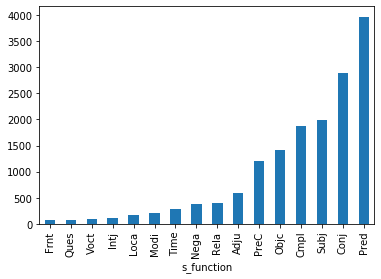

In [76]:
desc.loc['mean'].sort_values().plot(kind='bar')

The IQR can give us a better idea of dispersion.

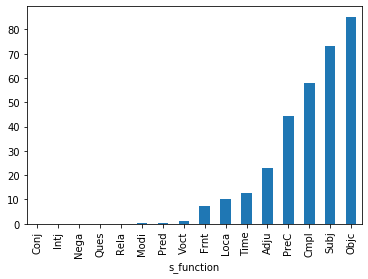

In [74]:
IQR = desc.loc['75%'] - desc.loc['25%'] # Levshina 2015: 49

IQR.sort_values().plot(kind='bar')

Now we can see two clear groups, those ranging from Conjunction to Vocatives,\
and those ranging from Fronted elements to Objects. One might draw a further \
subgroup within the latter, ranging from Adjunct to Objects.

The main thing we're interested in here is whether any of the functions would be\
negatively affected by selecting only single-phrase atom cases. In this case, the\
Object, Subject, and Complement functions have the largest spread and thus are most\
at risk for being affected by such a selection.

That risk is illustrated below by looking at the first and second quartiles.

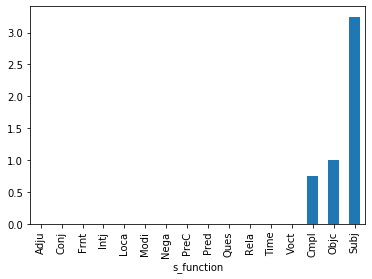

In [79]:
desc.loc['25%'].sort_values().plot(kind='bar')

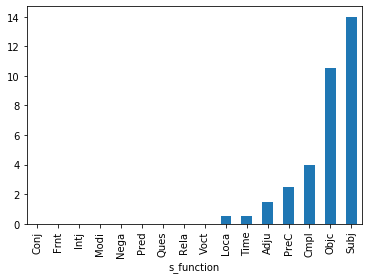

In [80]:
desc.loc['50%'].sort_values().plot(kind='bar')

Let's see what percentage values represent that lie below n_atoms = 1.

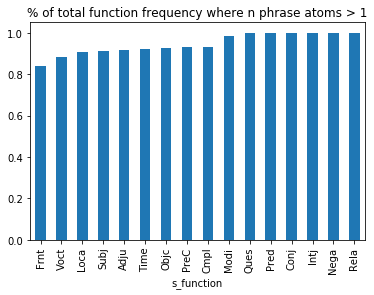

In [114]:
percentages = functXatoms_top[1].div(functXatoms_top.sum(1), 0).sort_values()

plt.figure()
ax = percentages.plot(kind='bar')
ax.set_title('% of total function frequency where n phrase atoms > 1')
plt.show()

In [115]:
percentages

s_function
Frnt    0.839930
Voct    0.881145
Loca    0.907429
Subj    0.909145
Adju    0.918121
Time    0.922386
Objc    0.925357
PreC    0.931323
Cmpl    0.932980
Modi    0.984217
Ques    0.999167
Pred    0.999543
Conj    1.000000
Intj    1.000000
Nega    1.000000
Rela    1.000000
dtype: float64

We can see here that the vast majority of functions have only one\
phrase atom. The types that stand to lose the largest proportions of\
their representative examples are:

In [117]:
largest_loss = percentages[percentages < 0.98]

largest_loss

s_function
Frnt    0.839930
Voct    0.881145
Loca    0.907429
Subj    0.909145
Adju    0.918121
Time    0.922386
Objc    0.925357
PreC    0.931323
Cmpl    0.932980
dtype: float64

However, these proportions are mostly negligible. However, the\
Fronted function is affected quite a bit ($16\%$)

In [119]:
1 - largest_loss 

s_function
Frnt    0.160070
Voct    0.118855
Loca    0.092571
Subj    0.090855
Adju    0.081879
Time    0.077614
Objc    0.074643
PreC    0.068677
Cmpl    0.067020
dtype: float64

The vocative is also negatively affected. Note that there is a drop-off after\
the vocative function, ranging from Location to Complements. It seems reasonable\
to consider this a cut-off point, taking those functions after the vocatives, which\
from then on are only affected by a <= 9% loss.

Those that will lose very little of their overall representation are:

In [123]:
smallest_loss = percentages[percentages > 0.98]

smallest_loss

s_function
Modi    0.984217
Ques    0.999167
Pred    0.999543
Conj    1.000000
Intj    1.000000
Nega    1.000000
Rela    1.000000
dtype: float64

In [124]:
1 - smallest_loss

s_function
Modi    0.015783
Ques    0.000833
Pred    0.000457
Conj    0.000000
Intj    0.000000
Nega    0.000000
Rela    0.000000
dtype: float64

However, some of these functions represent negligible proportions of\
of all functions with single phrase atoms:

In [127]:
total_percent = functXatoms_top[1].div(functXatoms_top.sum().sum(), 0).sort_values()

total_percent

s_function
Frnt    0.003791
Ques    0.004760
Voct    0.005621
Intj    0.007432
Loca    0.009456
Modi    0.012378
Time    0.017126
Nega    0.023994
Rela    0.025121
Adju    0.034677
PreC    0.071708
Objc    0.083272
Cmpl    0.111247
Subj    0.115320
Conj    0.183217
Pred    0.252062
Name: 1, dtype: float64

In [151]:
loss2total = pd.concat([percentages, total_percent], 1, sort=True)
loss2total.columns=['% kept', '% total']
loss2total

,% kept,% total
Adju,0.918121,0.034677
Cmpl,0.932980,0.111247
Conj,1.000000,0.183217
Frnt,0.839930,0.003791
Intj,1.000000,0.007432
Loca,0.907429,0.009456
Modi,0.984217,0.012378
Nega,1.000000,0.023994
Objc,0.925357,0.083272
PreC,0.931323,0.071708


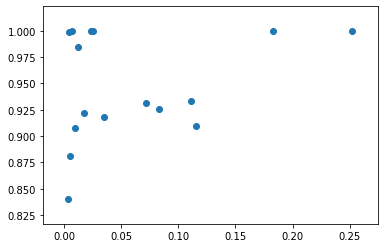

In [152]:
fig, ax = plt.subplots()
ax.scatter(x='% total', y='% kept', data=loss2total)

In [135]:
total_percent

s_function
Frnt    0.003791
Ques    0.004760
Voct    0.005621
Intj    0.007432
Loca    0.009456
Modi    0.012378
Time    0.017126
Nega    0.023994
Rela    0.025121
Adju    0.034677
PreC    0.071708
Objc    0.083272
Cmpl    0.111247
Subj    0.115320
Conj    0.183217
Pred    0.252062
Name: 1, dtype: float64

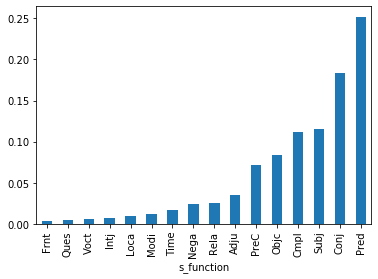

In [128]:
total_percent.plot(kind='bar')

It seems reasonable going forward to exclude such functions as:

    Fronted, lots of loss, small %
    Vocative, lots of loss, small %
    Question, small %
    Interjection, small %

In [129]:
exclude_functions = [
    'Frnt', 'Voct', 'Ques', 'Intj'
]

In [133]:
functXatoms2 = functXatoms_top.loc[~functXatoms_top.index.isin(exclude_functions)]

functXatoms2

n_phrase_atoms,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
s_function,,,,,,,,,,,,,,,,
Adju,8735.0,581.0,132.0,23.0,23.0,14.0,3.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
Cmpl,28023.0,1602.0,246.0,79.0,52.0,11.0,9.0,4.0,4.0,1.0,3.0,2.0,0.0,0.0,0.0,0.0
Conj,46152.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Loca,2382.0,182.0,36.0,10.0,10.0,3.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
Modi,3118.0,46.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Nega,6044.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Objc,20976.0,1163.0,265.0,114.0,77.0,30.0,14.0,13.0,8.0,2.0,3.0,1.0,0.0,1.0,1.0,0.0
PreC,18063.0,1064.0,132.0,72.0,35.0,14.0,8.0,4.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
Pred,63494.0,24.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We can also build another group, representing those phrase functions noted\
earlier which have more of a spread across n-atoms, and are thus more similar\
to the time phrase:

In [153]:
like_time = [
    'Loca', 'Subj', 'Adju',
    'Time', 'Objc', 'PreC',
    'Cmpl'
]

It's probably no coincidence these phrase functions are more similar\
in their spread of number of phrase atoms, since these more noun-based\
phrase types. Let's briefly confirm that.

In [160]:
functXtype = pd.pivot_table(
    phrase_df[phrase_df.n_phrase_atoms == 1], 
    index='s_function', 
    columns='type', 
    aggfunc='size'
).fillna(0)

In [161]:
functXtype

type,AdjP,AdvP,CP,DPrP,IPrP,InjP,InrP,NP,NegP,PP,PPrP,PrNP,VP
s_function,,,,,,,,,,,,,
Adju,0.0,0.0,0.0,0.0,0.0,0.0,0.0,352.0,0.0,8383.0,0.0,0.0,0.0
Cmpl,0.0,750.0,0.0,0.0,0.0,0.0,7.0,477.0,0.0,26504.0,0.0,285.0,0.0
Conj,0.0,0.0,46152.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
EPPr,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.0,0.0,0.0
Exst,0.0,0.0,0.0,0.0,0.0,0.0,0.0,157.0,0.0,0.0,0.0,0.0,0.0
Frnt,0.0,1.0,0.0,17.0,7.0,0.0,0.0,635.0,0.0,127.0,107.0,61.0,0.0
Intj,0.0,0.0,0.0,0.0,0.0,1872.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Loca,0.0,375.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,1886.0,0.0,21.0,0.0
Modi,0.0,3049.0,0.0,0.0,0.0,0.0,0.0,66.0,0.0,3.0,0.0,0.0,0.0


In [162]:
functXtype_percent = functXtype.div(functXtype.sum(1), 0)

functXtype_percent

type,AdjP,AdvP,CP,DPrP,IPrP,InjP,InrP,NP,NegP,PP,PPrP,PrNP,VP
s_function,,,,,,,,,,,,,
Adju,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.040298,0.0,0.959702,0.000000,0.000000,0.000000
Cmpl,0.000000,0.026764,0.000000,0.000000,0.000000,0.0,0.000250,0.017022,0.0,0.945795,0.000000,0.010170,0.000000
Conj,0.000000,0.000000,1.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
EPPr,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,1.000000,0.000000,0.000000
Exst,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,1.000000,0.0,0.000000,0.000000,0.000000,0.000000
Frnt,0.000000,0.001047,0.000000,0.017801,0.007330,0.0,0.000000,0.664921,0.0,0.132984,0.112042,0.063874,0.000000
Intj,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
Loca,0.000000,0.157431,0.000000,0.000000,0.000000,0.0,0.000000,0.041982,0.0,0.791772,0.000000,0.008816,0.000000
Modi,0.000000,0.977870,0.000000,0.000000,0.000000,0.0,0.000000,0.021167,0.0,0.000962,0.000000,0.000000,0.000000
